<a href="https://colab.research.google.com/github/Raspberry765/deep-metric-learning/blob/main/SubCenterArcFaceMNIST_LoF_issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmaxによる分類

In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install torchsummary
!pip install plotly==5.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchsummary import summary
import plotly.express as px
import plotly.graph_objects as go
from torch.utils.data.dataset import Subset
from torchvision.models.feature_extraction import create_feature_extractor

In [ ]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(15488, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
        #max_pool2dのstrideのデフォルトはkernel_size
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        #loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device) #0~9の数字を分類するため　10classに分類する、embedding_sizeは最終出力のunits数
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))
            numpy_loss = loss.cpu().detach().numpy()
            loss_list.append(numpy_loss)
            torch.save(model, "model_dml"+ str(epoch)+ "_" + str(batch_idx)  + ".pth")
            #print(numpy_loss)            
    return loss_list


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    ##Test set accuracy (Precision@1) = 0.9872000000000001
    return accuracies["precision_at_1"]




## View some sample outliers

In [ ]:


img_mean, img_std = (0.1307,), (0.3081,) #MNISTの平均と標準偏差  https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

In [ ]:

device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
) #MNISTの平均と標準偏差を画像に対して前処理を行うためのパラメーター



dataset1 = datasets.MNIST("./sample_data/", train=True, download=True, transform=transform) #トランスフォームを適用して、ダウンロード
dataset2 = datasets.MNIST("./sample_data/", train=False, transform=transform) #トランスフォームを適用して、ダウンロード



In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)

model = Net().to("cuda")

test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size) #batch sizeは2**n deep learning C2 w2 optimization algorithms
optimizer = optim.Adam(model.parameters(), lr=0.01)#defalut lr=0.01 #ハイパーパラメーター



### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device) #0~9の数字を分類するため　10classに分類する、embedding_sizeは最終出力のunits数
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)#ハイパーパラメーター
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

# train、validation、test datasetの作成
[train set validation testset役割](https://algorithm.joho.info/programming/python/keras-train-validation-test-dataset/)
[リンクテキスト](https://www.youtube.com/watch?v=swCf51Z8QDo)

In [ ]:

#print(device)
n_samples = int( len(dataset1) )  # n_samples is 60000
train_size = int( n_samples * 0.8 ) # train_size is 48000
val_size = n_samples - train_size

# shuffleしてから分割してくれる.
train_dataset, val_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size])

print(len(train_dataset)) # 48000
print(len(val_dataset)) # 12000

#print(torch.cuda.is_available())

48000
12000


# Modelの表示

In [ ]:
print(model)
summary(model,(1,28,28))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=15488, out_features=256, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 22, 22]          73,856
         Dropout2d-4          [-1, 128, 11, 11]               0
            Linear-5                  [-1, 256]       3,965,184
Total params: 4,057,856
Trainable params: 4,057,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB):

## Train the model

In [ ]:
sum_loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(1, num_epochs + 1):
    loss_list = train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    print(loss_list)
    sum_loss_list.extend(loss_list)
    acc_value = test(dataset1, dataset2, model, accuracy_calculator)
    acc_list.extend([acc_value])
print("sum_loss_list:",sum_loss_list)
print("acc_list:",acc_list)

Epoch 1 Iteration 0: Loss = 37.06086730957031
Epoch 1 Iteration 100: Loss = 9.772001266479492
Epoch 1 Iteration 200: Loss = 4.5825371742248535
Epoch 1 Iteration 300: Loss = 5.1700944900512695
Epoch 1 Iteration 400: Loss = 2.0361666679382324
Epoch 1 Iteration 500: Loss = 2.9860448837280273
Epoch 1 Iteration 600: Loss = 3.4942522048950195
Epoch 1 Iteration 700: Loss = 2.9746475219726562
Epoch 1 Iteration 800: Loss = 2.5567128658294678
Epoch 1 Iteration 900: Loss = 1.197535753250122
[array(37.060867, dtype=float32), array(9.772001, dtype=float32), array(4.582537, dtype=float32), array(5.1700945, dtype=float32), array(2.0361667, dtype=float32), array(2.986045, dtype=float32), array(3.4942522, dtype=float32), array(2.9746475, dtype=float32), array(2.5567129, dtype=float32), array(1.1975358, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 114.54it/s]


Computing accuracy


/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


Test set accuracy (Precision@1) = 0.9859
Epoch 2 Iteration 0: Loss = 2.5438661575317383
Epoch 2 Iteration 100: Loss = 1.8538179397583008
Epoch 2 Iteration 200: Loss = 1.3571114540100098
Epoch 2 Iteration 300: Loss = 2.442434549331665
Epoch 2 Iteration 400: Loss = 2.045236110687256
Epoch 2 Iteration 500: Loss = 2.3718459606170654
Epoch 2 Iteration 600: Loss = 2.4672484397888184
Epoch 2 Iteration 700: Loss = 3.1117281913757324
Epoch 2 Iteration 800: Loss = 2.07034969329834
Epoch 2 Iteration 900: Loss = 3.1877169609069824
[array(2.5438662, dtype=float32), array(1.8538179, dtype=float32), array(1.3571115, dtype=float32), array(2.4424345, dtype=float32), array(2.045236, dtype=float32), array(2.371846, dtype=float32), array(2.4672484, dtype=float32), array(3.1117282, dtype=float32), array(2.0703497, dtype=float32), array(3.187717, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 115.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9876
sum_loss_list: [array(37.060867, dtype=float32), array(9.772001, dtype=float32), array(4.582537, dtype=float32), array(5.1700945, dtype=float32), array(2.0361667, dtype=float32), array(2.986045, dtype=float32), array(3.4942522, dtype=float32), array(2.9746475, dtype=float32), array(2.5567129, dtype=float32), array(1.1975358, dtype=float32), array(2.5438662, dtype=float32), array(1.8538179, dtype=float32), array(1.3571115, dtype=float32), array(2.4424345, dtype=float32), array(2.045236, dtype=float32), array(2.371846, dtype=float32), array(2.4672484, dtype=float32), array(3.1117282, dtype=float32), array(2.0703497, dtype=float32), array(3.187717, dtype=float32)]
acc_list: [0.9859, 0.9876]


# lossをプロットするとaccをプロットする

20


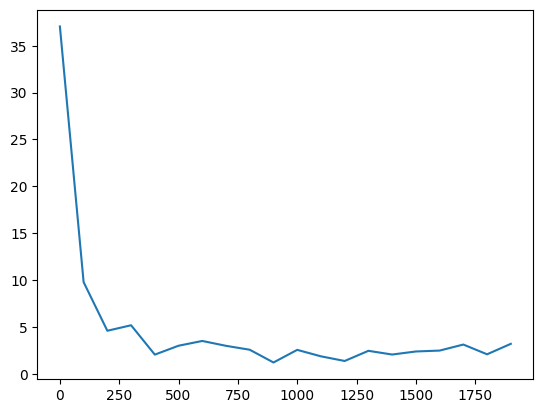

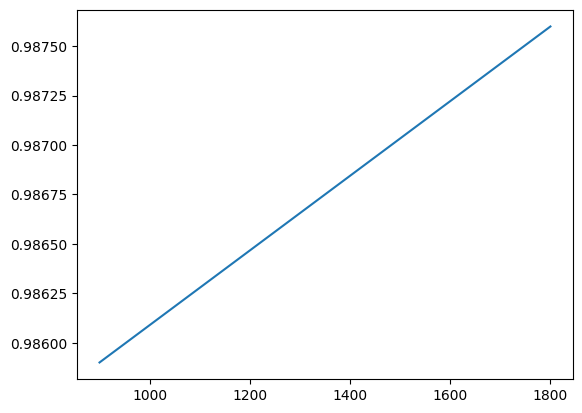

In [ ]:
#print(type(loss_list[0]))
print(len(sum_loss_list))
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

x2 = (np.arange(len(acc_list))+1 )*900 #-5から5まで0.1区切りで配列を作る
y2 = acc_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成


plt.plot(x,y) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()
plt.plot(x2,y2) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()

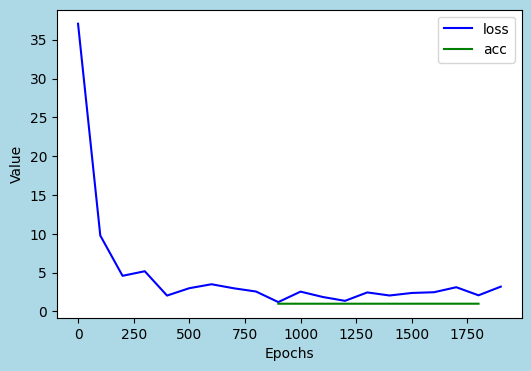

In [ ]:
fig = plt.figure(figsize = (6,4), facecolor='lightblue')

c1, c2 = 'blue', 'green'
l1, l2 = 'loss', 'acc'
plt.plot(x, y, color=c1, label=l1)
plt.plot(x2, y2, color=c2, label=l2)

#ラベルを追加
plt.xlabel("Epochs")
plt.ylabel("Value")


# 凡例表示
plt.legend(loc = 'upper right') 

plt.show()

In [ ]:
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

fig = go.Figure()
fig.add_trace(
go.Scatter(x=x,y=y)
)
fig.update_layout(
    xaxis_title = 'Number of Epoch',
    yaxis_title = 'Loss'
)
fig.show()

In [ ]:
x2 = (np.arange(len(acc_list))+1 )*900 #-5から5まで0.1区切りで配列を作る
y2 = acc_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

fig = go.Figure()
fig.add_trace(
go.Scatter(x=x2,y=y2)
)
fig.update_layout(
    xaxis_title = 'Number of Epoch',
    yaxis_title = 'acc'
)
fig.show()

# modelを保存

In [ ]:
torch.save(model, 'model_dml.pth')

#modelデータのロードをする
# trainデータを埋め込みする



In [ ]:
load_model = torch.load('model_dml.pth')
train_embeddings, train_labels = get_all_embeddings(dataset1, load_model)

100%|██████████| 1875/1875 [00:22<00:00, 83.31it/s] 


## Get outliers(MNISTの文字データのtrainデータを異常検知している)

There are 81 outliers


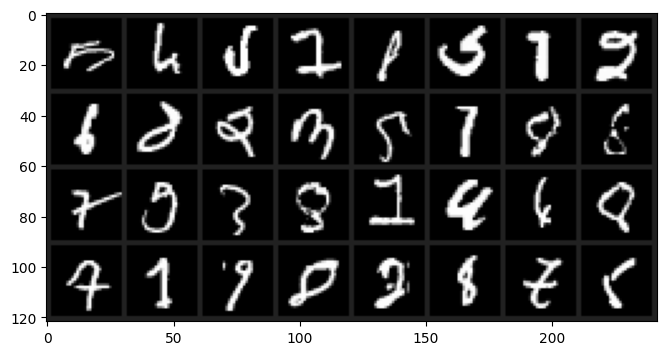

In [ ]:
#get_outliers( embeddings, labels, threshold=75, return_dominant_centers=True)
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers")
imshow_many(dataset1, outliers)

In [ ]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers


# testデータを埋め込みする

In [ ]:
test_embeddings, test_labels = get_all_embeddings(dataset2, model)

100%|██████████| 313/313 [00:04<00:00, 65.23it/s]


## Get outliers(MNISTの文字データのtestデータを異常検知している)

There are 18 outliers(MNIST 10000 test items)


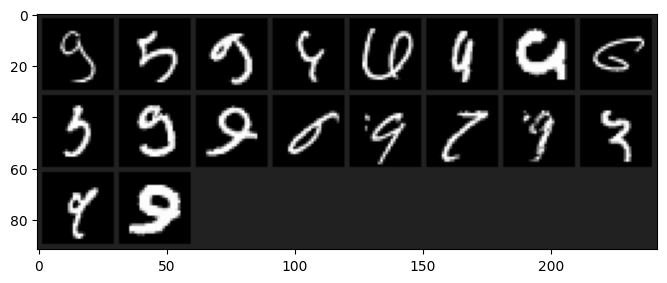

In [ ]:
outliers, _ = loss_func.get_outliers(test_embeddings, test_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(MNIST 10000 test items)")
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset2, outliers)